<a href="https://colab.research.google.com/github/demichie/PhD_ModelingCourse/blob/main/Lecture3/Lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical Exercise: 1D Heat Diffusion in Python

Let's implement the 1D heat equation numerically using finite differences.
We will simulate temperature diffusion along a 1D domain (e.g., a rod or a vertical soil/rock profile).

**Equation:**
$$ \frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2} $$

**Numerical Scheme (FTCS - Forward Time, Central Space):**
$$ T_i^{n+1} = T_i^n + \alpha (T_{i+1}^n - 2T_i^n + T_{i-1}^n) $$
where $\alpha = \kappa \frac{\Delta t}{\Delta x^2}$.

**Stability Condition:** For this explicit scheme, we need $\alpha \leq \frac{1}{2}$, which means $\Delta t \leq \frac{\Delta x^2}{2\kappa}$.

### Problem Setup: Initial and Boundary Conditions

We'll simulate a scenario with the following conditions:

1.  **Spatial Domain:** A 1D domain of length $L$.
2.  **Initial Condition ($t=0$):** A "hot pulse" in the center of the domain.
    $$ T(x,0) = \begin{cases} 100^\circ C & \text{if } 0.4L < x < 0.6L \\ 20^\circ C & \text{elsewhere} \end{cases} $$
3.  **Boundary Conditions (for all $t > 0$):** Fixed temperatures (Dirichlet conditions) at both ends.
    $$ T(0,t) = T_L = 20^\circ C $$
    $$ T(L,t) = T_R = 20^\circ C $$
    (Here $T_L$ and $T_R$ are the temperatures at the left and right boundaries, respectively).

Let's set up the parameters and define the initial temperature profile in Python.

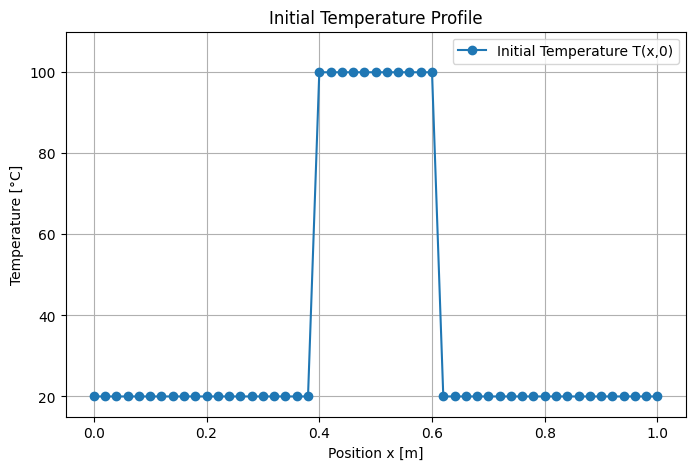

Domain length L: 1.0 m
Number of grid points Nx: 51
Grid spacing dx: 0.0200 m
Thermal diffusivity kappa: 1.0e-06 m^2/s


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
L = 1.0             # Length of the domain [m]
Nx = 51             # Number of spatial grid points
dx = L / (Nx - 1)   # Spatial grid spacing [m]

# Create the spatial grid
x_grid = np.linspace(0, L, Nx)

# Thermal diffusivity (example for rock/soil, can be varied)
kappa = 1e-6        # [m^2/s]

# Temperatures for initial and boundary conditions
T_cold = 20.0       # [degC]
T_hot = 100.0       # [degC]
T_boundary_left = T_cold
T_boundary_right = T_cold

# --- Initial Condition ---
# Initialize temperature array with the cold temperature
T_initial = np.full(Nx, T_cold) # Or np.ones(Nx) * T_cold

# Set the hot pulse in the center using a loop and if condition
# Define the pulse region
x_pulse_start = 0.4 * L
x_pulse_end = 0.6 * L

for i in range(Nx):
    if x_grid[i] >= x_pulse_start and x_grid[i] <= x_pulse_end:
        T_initial[i] = T_hot

# --- Plot Initial Condition ---
plt.figure(figsize=(8, 5))
plt.plot(x_grid, T_initial, marker='o', linestyle='-', label='Initial Temperature T(x,0)')
plt.xlabel('Position x [m]')
plt.ylabel('Temperature [°C]')
plt.title('Initial Temperature Profile')
plt.ylim(T_cold - 5, T_hot + 10) # Adjust ylim for better visualization
plt.grid(True)
plt.legend()
plt.show()

print(f"Domain length L: {L} m")
print(f"Number of grid points Nx: {Nx}")
print(f"Grid spacing dx: {dx:.4f} m")
print(f"Thermal diffusivity kappa: {kappa:.1e} m^2/s")
# Store T_initial for later use in the main simulation
T_current = T_initial.copy()

### Simulation: Solving the 1D Heat Equation

Now we'll implement the time-stepping loop to solve the heat equation using the FTCS scheme.

**Parameters for Time Stepping:**
*   `dt`: Time step size. Must satisfy the stability condition $\Delta t \leq \frac{\Delta x^2}{2\kappa}$.
*   `t_final`: Total simulation time.
*   `Nt`: Total number of time steps.

We will also store the temperature profiles at selected times for later visualization.

Chosen alpha: 0.55
Calculated time step dt: 220.0000 s
Total simulation time t_final: 100000.0 s
Number of time steps Nt: 454
Simulation finished.


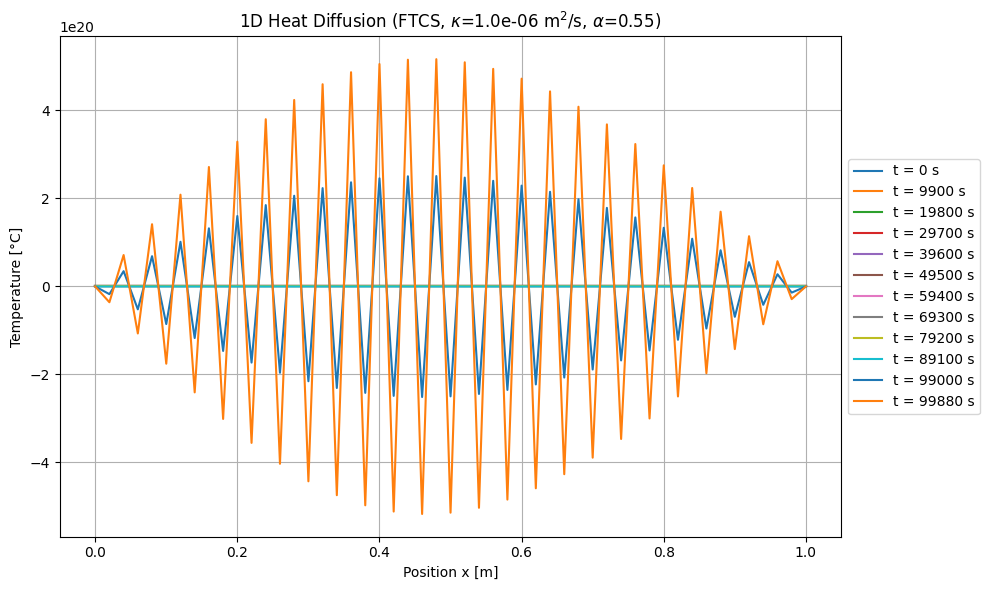

In [6]:
# (Assumes kappa, dx, Nx, T_current, T_boundary_left, T_boundary_right are defined from previous cell)

# --- Time Stepping Parameters ---
# Calculate stable dt based on the stability criterion
# alpha = kappa * dt / dx**2 <= 0.5  => dt <= 0.5 * dx**2 / kappa
alpha_value = 0.55 # Choose a value for alpha (e.g., 0.45, slightly less than 0.5 for safety)
dt = alpha_value * dx**2 / kappa

t_final = 100000.0 # Total simulation time [s] (adjust as needed for your kappa)
                  # Example: for kappa=1e-6, L=1, dx=0.02, dt approx 80s.
                  # To see significant diffusion, t_final might need to be large.
                  # Characteristic diffusion time is ~ L^2 / kappa.
                  # Here, L^2/kappa = 1^2 / 1e-6 = 1,000,000 s.
                  # So, t_final = 100,000s is 10% of characteristic time.

Nt = int(t_final / dt)   # Number of time steps

print(f"Chosen alpha: {alpha_value}")
print(f"Calculated time step dt: {dt:.4f} s")
print(f"Total simulation time t_final: {t_final:.1f} s")
print(f"Number of time steps Nt: {Nt}")

# --- Array to store results at selected times (optional) ---
# For example, store every 'output_interval' steps
output_interval_steps = max(1, Nt // 10) # Store ~10 profiles + initial
if Nt < 10 and Nt > 0 : output_interval_steps = 1 # Ensure we output if few steps

T_results = [T_current.copy()] # Store initial condition
t_results = [0.0]

# --- Time Stepping Loop (FTCS) ---
T_previous_step = T_current.copy() # Array for T at time n

for n in range(1, Nt + 1): # Loop from t_step 1 to Nt
    # Update interior points
    for i in range(1, Nx - 1): # Loop over spatial points, excluding boundaries
        T_current[i] = T_previous_step[i] + \
                       alpha_value * (T_previous_step[i+1] - 2*T_previous_step[i] + T_previous_step[i-1])

    # Apply Boundary Conditions (Dirichlet)
    T_current[0] = T_boundary_left   # Temperature at x=0
    T_current[Nx-1] = T_boundary_right # Temperature at x=L (or T_current[-1])

    # Update T_previous_step for the next iteration
    T_previous_step = T_current.copy()

    # Store results (optional)
    if n % output_interval_steps == 0 or n == Nt:
        T_results.append(T_current.copy())
        t_results.append(n * dt)

print("Simulation finished.")

# --- Plotting Selected Results ---
plt.figure(figsize=(10, 6))
num_profiles_to_plot = len(T_results)
# colors = plt.cm.viridis(np.linspace(0, 1, num_profiles_to_plot))

for k in range(num_profiles_to_plot):
    plt.plot(x_grid, T_results[k], label=f't = {t_results[k]:.0f} s') #, color=colors[k])

plt.xlabel('Position x [m]')
plt.ylabel('Temperature [°C]')
plt.title(f'1D Heat Diffusion (FTCS, $\kappa$={kappa:.1e} m$^2$/s, $\\alpha$={alpha_value})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout() # Adjust layout to make space for legend
plt.show()

### Creating an Animation of the Solution

While static plots of temperature profiles at different times are useful, an **animation** can provide a much more intuitive understanding of how the temperature field evolves dynamically. We can create an animation using Matplotlib's `animation` module.

**The Core Idea of Animation:**
An animation is essentially a sequence of static images (frames) displayed rapidly one after another, creating the illusion of motion or change over time. To create it with Matplotlib, we need to:

1.  **Set up a Figure:** Create a Matplotlib figure and an axis, just like for a static plot. This will be the "canvas" for our animation.
2.  **Initial Plot Element:** Plot the first frame (e.g., our initial temperature profile) on this figure. We get a "line object" (or other plot artists) that we can then update.
3.  **Update Function:** Define a Python function that tells Matplotlib how to change the plot for each subsequent frame. This function will typically:
    *   Take a `frame_index` as input.
    *   Use this index to get the data for the current frame (e.g., `T_results[frame_index]`).
    *   Update the properties of our line object (e.g., its y-data) with this new data.
4.  **Animation Object:** Use `matplotlib.animation.FuncAnimation` to orchestrate the process. This function repeatedly calls our update function to generate all the frames.
5.  **Display/Save:** Display the animation in the notebook or save it to a file (like a GIF or MP4).

Let's see how this is done in Python.

### Key Components for `FuncAnimation`

When we use `FuncAnimation`, we'll interact with these main components:

*   **`fig`**: The Matplotlib figure object on which the animation is drawn.
*   **`update_animation(frame_index)` function**:
    *   This is a function *you define*.
    *   It's called for each frame of the animation.
    *   `frame_index` is an integer that typically goes from 0 to `number_of_frames - 1`.
    *   Its job is to modify the artists on the plot (e.g., the y-data of a line) to reflect the state of the system at the `frame_index`.
    *   It must return a tuple of the artists that were modified.
*   **`frames`**: The total number of frames to generate. For us, this will be the number of temperature profiles we stored in `T_results`.
*   **`init_func` (optional but good practice, especially with `blit=True`):**
    *   A function *you define* that is called once at the beginning to set up the plot before the first frame is drawn. It's used to draw a "clean slate" or initial background.
    *   It must also return a tuple of the artists.
*   **`interval`**: The delay between frames in milliseconds (e.g., `100` ms for 10 frames per second).
*   **`blit` (optional, `True` or `False`):**
    *   If `True`, `FuncAnimation` tries to optimize drawing by only redrawing plot elements that have changed. This can make animations smoother but can sometimes be tricky to set up correctly or cause issues with certain Matplotlib backends.
    *   If `False`, the entire frame is redrawn each time. This is simpler but can be slower.

Now, let's implement this to animate our heat diffusion simulation results.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation # Per l'animazione
from IPython.display import HTML # Per visualizzare l'animazione nel notebook

In [4]:
# (Assume x_grid, T_results, t_results, L, T_cold, T_hot are defined
#  from previous code cells)

# --- Import necessary modules for animation ---
from matplotlib.animation import FuncAnimation # For creating the animation
from IPython.display import HTML, display    # For displaying the animation in the notebook

# --- Create the Animation ---

# Set up the figure and axis for the animation
fig_anim, ax_anim = plt.subplots(figsize=(8, 5))
ax_anim.set_xlim(0, L)  # L should be defined (e.g., L=1.0)
ax_anim.set_ylim(T_cold - 5, T_hot + 10) # Use min/max temperatures for y-limits
ax_anim.set_xlabel('Position x [m]')
ax_anim.set_ylabel('Temperature [°C]')
ax_anim.set_title('1D Heat Diffusion Animation')
ax_anim.grid(True)

# Initialize the line object that will be updated in the animation
# Start with the first temperature profile (initial condition)
line, = ax_anim.plot(x_grid, T_results[0], lw=2, color='dodgerblue') # Added a color

# Add text to display the current time
time_text = ax_anim.text(0.05, 0.90, '', transform=ax_anim.transAxes, fontsize=12)

# Initialization function for the animation (required for blitting)
def init_animation():
    line.set_ydata(np.ma.array(x_grid, mask=True)) # Hide the line initially for blitting
    time_text.set_text('')
    return line, time_text

# Function that updates the figure for each animation frame
def update_animation(frame_index):
    # frame_index will go from 0 to len(T_results) - 1
    current_T_profile = T_results[frame_index]
    current_time = t_results[frame_index]

    line.set_ydata(current_T_profile) # Update the y-data of the line
    time_text.set_text(f'Time = {current_time:.1f} s') # Update the time text
    return line, time_text

# Create the animation object
# frames: the number of frames to generate (corresponds to the number of saved profiles)
# interval: delay between frames in milliseconds (e.g., 100ms = 10 fps)
# blit=True: optimization to redraw only what has changed (can cause issues with some backends)
#            If blit=True causes problems, try blit=False.
# repeat=False: the animation will not loop
num_frames = len(T_results)
animation_interval_ms = 100 # Milliseconds per frame

# Check if there are frames to animate
if num_frames > 0:
    ani = FuncAnimation(fig_anim, update_animation, frames=num_frames,
                        init_func=init_animation, blit=True,
                        interval=animation_interval_ms, repeat=False)

    # Display the animation in the Jupyter Notebook
    # This converts the animation to HTML5 video or JavaScript/HTML
    # Using to_jshtml() is often more compatible with modern notebooks.
    try:
        display_html_object = HTML(ani.to_jshtml())
        display(display_html_object)
        plt.close(fig_anim) # Close the static animation figure to avoid double display
    except Exception as e:
        print(f"Error creating HTML animation: {e}")
        print("This might require ffmpeg or trying a different Matplotlib backend.")
        print("Attempting to show animation using Matplotlib's default backend (may open in a new window).")
        plt.show() # Fallback if to_jshtml() fails
else:
    print("No simulation results found to animate (T_results is empty or has only one frame).")
    plt.close(fig_anim) # Close the empty figure

# Optional: Save the animation to a file (e.g., GIF or MP4)
# This usually requires 'imagemagick' (for GIF) or 'ffmpeg' (for MP4) to be installed.
# Example for saving as GIF:
# if num_frames > 0:
#     try:
#         ani.save('heat_diffusion_animation.gif', writer='imagemagick', fps=10)
#         print("Animation saved as heat_diffusion_animation.gif")
#     except Exception as e:
#         print(f"Error saving GIF: {e}. Ensure ImageMagick is installed and in PATH.")

# Example for saving as MP4:
# if num_frames > 0:
#     try:
#         ani.save('heat_diffusion_animation.mp4', writer='ffmpeg', fps=15, dpi=150)
#         print("Animation saved as heat_diffusion_animation.mp4")
#     except Exception as e:
#         print(f"Error saving MP4: {e}. Ensure FFmpeg is installed and in PATH.")

### A. Experimenting with Parameters (Dirichlet BCs)

The numerical solution we've implemented allows us to explore how different physical and numerical parameters affect heat diffusion. Let's consider a few scenarios.

**Things to Try (modify the simulation cell above and re-run):**

1.  **Thermal Diffusivity (`kappa`):**
    *   **Increase `kappa`** (e.g., to `5e-6` or `1e-5` m²/s): What happens to the rate of diffusion? How quickly does the initial hot pulse spread and cool down?
    *   **Decrease `kappa`** (e.g., to `5e-7` or `1e-7` m²/s): How does this affect the diffusion process?
    *(Remember that if you change `kappa` or `dx`, you might need to adjust `dt` to maintain stability, or re-calculate it based on your chosen `alpha_value`)*

2.  **Spatial Discretization (`Nx`, which affects `dx`):**
    *   **Increase `Nx`** (e.g., to `101` points, making `dx` smaller): Does this provide a "smoother" or more detailed solution? How does it affect the `dt` required for stability (if `alpha_value` is fixed)?
    *   **Decrease `Nx`** (e.g., to `21` points, making `dx` larger): How does the solution change? What happens to the `dt` for stability?

3.  **Stability Parameter (`alpha_value`):**
    *   Try setting `alpha_value` very close to `0.5` (e.g., `0.49` or `0.5`). Is the solution still stable?
    *   **Carefully try `alpha_value > 0.5`** (e.g., `0.51` or `0.6`). What happens to the solution? You should observe numerical instability (oscillations, unphysical values). *Remember to set it back to a stable value like 0.45 afterwards!*

4.  **Initial Condition:**
    *   Change the `x_pulse_start` and `x_pulse_end` to make the initial hot pulse wider or narrower, or shift its position.
    *   Try a different shape for the initial condition (e.g., a linear gradient, a sine wave).

5.  **Boundary Temperatures (`T_boundary_left`, `T_boundary_right`):**
    *   What if one boundary is hot and the other is cold (e.g., `T_boundary_left = 100`, `T_boundary_right = 20`)? How does the system evolve towards a steady state?

**Instructions:**
*   Go back to the main simulation cell (the one starting with `# --- Time Stepping Parameters ---`).
*   Modify one parameter at a time.
*   Re-run that cell (and the animation cell if you want to see the animation).
*   Observe the changes in the plotted results or the animation.
*   Think about *why* the solution changes in that way.

### B. Implementing Neumann (Zero-Flux / Symmetry) Boundary Conditions

So far, we've used Dirichlet boundary conditions, where we fix the *value* of the temperature at the boundaries. Another common type is the **Neumann boundary condition**, where we specify the *gradient* (or flux) of the temperature.

A special case is a **zero-gradient (or zero-flux) condition**:
$$ \frac{\partial T}{\partial x} = 0 $$
This physically represents an insulated boundary (no heat flows across it) or a plane of symmetry.

**Approximating the Zero-Gradient Condition:**
Let's say we want $\frac{\partial T}{\partial x} = 0$ at the left boundary ($x=0$, which is point $i=0$). We can use a finite difference approximation for the derivative at $x=0$.

*   **Using a Forward Difference (1st order accurate) at $i=0$:**
    $$ \frac{T_1^n - T_0^n}{\Delta x} = 0 \quad \Rightarrow \quad T_0^n = T_1^n $$
    This means the temperature at the boundary point $i=0$ is set to be the same as its interior neighbor $i=1$.

*   **Using a Central Difference (2nd order accurate, requires a "ghost point"):**
    A more accurate way involves introducing a "ghost point" $T_{-1}^n$ outside the domain.
    $$ \frac{T_1^n - T_{-1}^n}{2\Delta x} = 0 \quad \Rightarrow \quad T_{-1}^n = T_1^n $$
    Then, we apply the standard FTCS formula at $i=0$:
    $$ T_0^{n+1} = T_0^n + \alpha (T_{1}^n - 2T_0^n + T_{-1}^n) $$
    Substituting $T_{-1}^n = T_1^n$:
    $$ T_0^{n+1} = T_0^n + \alpha (T_{1}^n - 2T_0^n + T_{1}^n) = T_0^n + 2\alpha (T_{1}^n - T_0^n) $$

For simplicity in this first example, we will implement the **first-order accurate method ($T_0^n = T_1^n$) applied at the *new* time level ($T_0^{n+1} = T_1^{n+1}$)**. This is a common and straightforward way to handle it within an explicit scheme.

**Scenario:**
*   Left boundary ($x=0$): Zero gradient (symmetry/insulation), $\frac{\partial T}{\partial x} = 0$.
*   Right boundary ($x=L$): Fixed temperature (Dirichlet), $T(L,t) = T_{\text{cold}}$.
*   Initial Condition: Hot pulse near the left boundary (to see the effect of symmetry).

Starting Neumann BC simulation with dt=180.00s, Nt=555 steps.
Neumann BC simulation finished.


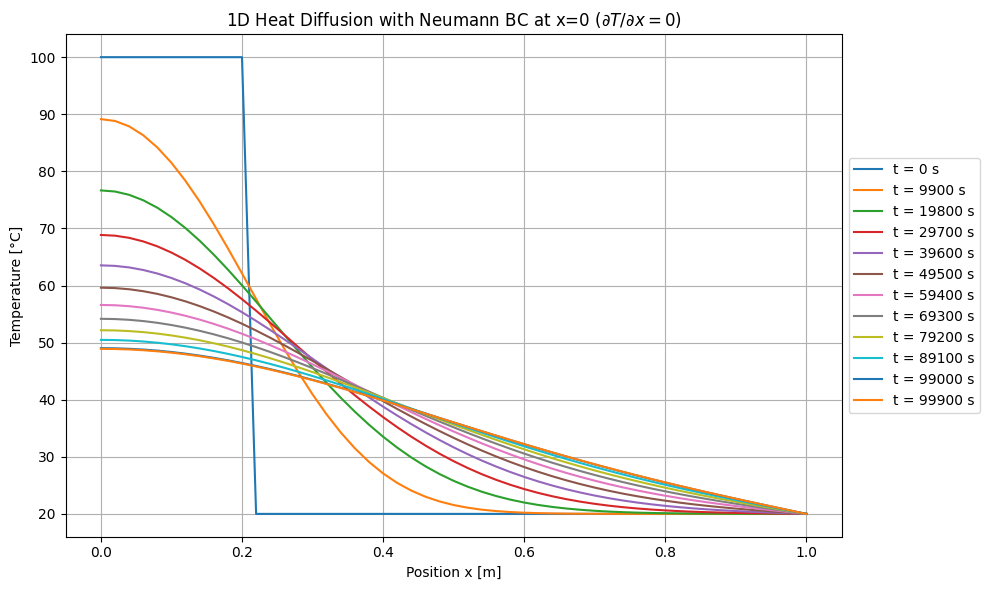

In [5]:
# --- Neumann BC Simulation ---

# Parameters (can reuse some from before, like L, Nx, dx, kappa, T_cold, T_hot)
# Let's redefine the initial condition to be near the left boundary
T_initial_neumann = np.full(Nx, T_cold)
x_pulse_start_neumann = 0.0 * L # Start pulse at the left boundary
x_pulse_end_neumann = 0.2 * L   # Pulse width 20% of L

for i in range(Nx):
    if x_grid[i] >= x_pulse_start_neumann and x_grid[i] <= x_pulse_end_neumann:
        T_initial_neumann[i] = T_hot

T_current_neumann = T_initial_neumann.copy()
T_boundary_right_neumann = T_cold # Right boundary is still Dirichlet

# Time stepping parameters (can reuse alpha_value, calculate new dt if dx changed)
# If dx and kappa are the same as before, dt will be the same.
# alpha_value = 0.45 # Ensure this is set from a previous cell or here
# dt_neumann = alpha_value * dx**2 / kappa # dx, kappa should be defined
# t_final_neumann = 100000.0 # Adjust as needed
# Nt_neumann = int(t_final_neumann / dt_neumann)

# Use dt, t_final, Nt from the previous simulation section for consistency,
# or redefine them here if needed. For this example, let's assume they are good.
# If they were not defined in the global scope of the notebook, you need to redefine:
if 'dt' not in globals(): # Basic check, or just redefine them
    print("Redefining dt, t_final, Nt for Neumann simulation")
    alpha_value = 0.45
    dt = alpha_value * dx**2 / kappa
    t_final = 100000.0
    Nt = int(t_final / dt)

print(f"Starting Neumann BC simulation with dt={dt:.2f}s, Nt={Nt} steps.")

# --- Array to store results ---
T_results_neumann = [T_current_neumann.copy()]
t_results_neumann = [0.0]

# output_interval_steps should also be defined from previous section or redefined
if 'output_interval_steps' not in globals():
    output_interval_steps = max(1, Nt // 10)


# --- Time Stepping Loop (FTCS with Neumann on left, Dirichlet on right) ---
T_previous_step_neumann = T_current_neumann.copy()

for n in range(1, Nt + 1):
    # Update interior points (i from 1 to Nx-2)
    for i in range(1, Nx - 1):
        T_current_neumann[i] = T_previous_step_neumann[i] + \
            alpha_value * (T_previous_step_neumann[i+1] - 2*T_previous_step_neumann[i] + T_previous_step_neumann[i-1])

    # Apply Boundary Conditions
    # Left Boundary (i=0): Neumann (Zero Gradient, T0 = T1)
    # We apply this using the newly computed T1 at step n+1 to determine T0 at n+1.
    # However, since T_current_neumann[1] was calculated using T_previous_step_neumann,
    # to be fully explicit and simple for T0:
    # T_current_neumann[0] = T_current_neumann[1]
    # A slightly more accurate explicit way (using values at time n for the gradient approx):
    T_current_neumann[0] = T_previous_step_neumann[1] # Based on T0_new = T1_old (after T1_old was used to update T1_new)
                                                    # Or more directly by modifying the FTCS for i=0 with ghost point T-1 = T1
                                                    # FTCS at i=0: T0_new = T0_old + alpha*(T1_old - 2*T0_old + T(-1)_old)
                                                    # With T(-1)_old = T1_old:
                                                    # T0_new = T0_old + alpha*(T1_old - 2*T0_old + T1_old)
                                                    # T0_new = T0_old + 2*alpha*(T1_old - T0_old)
    # Let's use the simpler T0_new = T1_new (after T1_new is computed)
    # T_current_neumann[0] = T_current_neumann[1] is okay for first-order BC.
    # For more careful explicit implementation of Neumann at i=0 using previous time step values for gradient:
    # T_current_neumann[0] = T_previous_step_neumann[0] + 2.0 * alpha_value * (T_previous_step_neumann[1] - T_previous_step_neumann[0])
    # This one comes from the ghost point method described in the markdown.

    # Let's stick to the most straightforward first-order implementation for clarity for beginners:
    # After T_current_neumann[1] is updated based on T_previous_step_neumann values,
    # we set T_current_neumann[0] to match it.
    # The loop for interior points goes up to Nx-2, so T_current_neumann[1] is computed.
    # Then we can set T_current_neumann[0].
    # This approach (T0_new = T1_new) is common but can be slightly phase-lagged for the BC.
    # A better explicit choice derived from discretizing at the boundary:
    T_current_neumann[0] = T_previous_step_neumann[0] + 2.0 * alpha_value * (T_previous_step_neumann[1] - T_previous_step_neumann[0])


    # Right Boundary (i=Nx-1): Dirichlet
    T_current_neumann[Nx-1] = T_boundary_right_neumann

    # Update T_previous_step for the next iteration
    T_previous_step_neumann = T_current_neumann.copy()

    # Store results
    if n % output_interval_steps == 0 or n == Nt:
        T_results_neumann.append(T_current_neumann.copy())
        t_results_neumann.append(n * dt)

print("Neumann BC simulation finished.")

# --- Plotting Neumann Results ---
plt.figure(figsize=(10, 6))
num_profiles_to_plot_neumann = len(T_results_neumann)
# colors_neumann = plt.cm.winter(np.linspace(0, 1, num_profiles_to_plot_neumann))

for k in range(num_profiles_to_plot_neumann):
    plt.plot(x_grid, T_results_neumann[k], label=f't = {t_results_neumann[k]:.0f} s') #, color=colors_neumann[k])

plt.xlabel('Position x [m]')
plt.ylabel('Temperature [°C]')
plt.title(f'1D Heat Diffusion with Neumann BC at x=0 ($\\partial T/\\partial x = 0$)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Animation for Neumann (optional, use the same animation code structure as before) ---
# fig_anim_N, ax_anim_N = plt.subplots(...)
# ... setup ...
# line_N, = ax_anim_N.plot(x_grid, T_results_neumann[0], ...)
# time_text_N = ax_anim_N.text(...)
# def init_animation_N(): ...
# def update_animation_N(frame_index):
#     line_N.set_ydata(T_results_neumann[frame_index])
#     time_text_N.set_text(f'Time = {t_results_neumann[frame_index]:.1f} s')
#     return line_N, time_text_N
# ani_N = FuncAnimation(fig_anim_N, update_animation_N, ...)
# HTML(ani_N.to_jshtml())
# plt.close(fig_anim_N)